In [229]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import metrics 
from tensorflow.keras.layers import Layer,Add, add,AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D ,Lambda ,GlobalAveragePooling2D,DepthwiseConv2D
from tensorflow.keras.layers import concatenate, Add, BatchNormalization, Activation, PReLU, LeakyReLU ,Reshape,Multiply, multiply
from tensorflow.keras import regularizers , Input ,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage , misc


In [230]:
BATCH_SIZE = 64
epochs = 20
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_CHANNEL = 3
QP = "QP37"
total_train = 717720
# total_valid = 62704
# total_train = 312914
total_valid = 62704

# Data Generator

In [231]:
df = pd.read_pickle("D:/TrainEnd2End/QP37.pkl").head(32)
df

,filepath,QTMT,TT,QT
0,D:/TrainEnd2End/QP37/CU_intra_train_1_0.png,2,0,3
1,D:/TrainEnd2End/QP37/CU_intra_train_1_1.png,2,1,3
2,D:/TrainEnd2End/QP37/CU_intra_train_1_2.png,2,1,2
3,D:/TrainEnd2End/QP37/CU_intra_train_1_3.png,2,1,3
4,D:/TrainEnd2End/QP37/CU_intra_train_1_4.png,0,0,2
5,D:/TrainEnd2End/QP37/CU_intra_train_1_5.png,1,1,2
6,D:/TrainEnd2End/QP37/CU_intra_train_1_6.png,2,1,3
7,D:/TrainEnd2End/QP37/CU_intra_train_1_7.png,2,0,3
8,D:/TrainEnd2End/QP37/CU_intra_train_1_8.png,1,1,2
9,D:/TrainEnd2End/QP37/CU_intra_train_1_9.png,2,1,3


In [228]:
def training_data_generator(QTMTlabels, QTlabels_1, QTlabels_2, QTlabels_3, TTlabels, image_path):
    # load in the image according to image path
    #path = image_path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img*1./255
    QTMTlabels = tf.cast(QTMTlabels, tf.float32)
    QTlabels_1 = tf.cast(QTlabels_1, tf.float32)
    QTlabels_2 = tf.cast(QTlabels_2, tf.float32)
    QTlabels_3 = tf.cast(QTlabels_3, tf.float32)
    TTlabels = tf.cast(TTlabels, tf.int32)
    #tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)
    return img, (QTMTlabels, QTlabels_1, QTlabels_2, QTlabels_3, TTlabels)# tuple

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    QTMT = df['QTMT'].values
    QT = df['QT'].values
    TT = df['TT'].values
    image = df['filepath'].values
    QTMTlabels = []
    QTlabels_1 = [] #complex
    QTlabels_2 = [] #moderate
    QTlabels_3 = [] #smooth
    TTlabels = []
    image_path = []
    for i in range(len(QTMT)):

        #QTMTlabels.append(QTMT[i])
        image_path.append(image[i])
        if(QTMT[i] == 0): #smooth
            QTMTlabels.append([1,0,0])
            if(QT[i] == 3 or QT[i] == 2):
                QTlabels_1.append([0,1])
                QTlabels_2.append([0,1])
                QTlabels_3.append([0,1])
            else:
                QTlabels_1.append([1,0])
                QTlabels_2.append([1,0])
                QTlabels_3.append([1,0])
        elif(QTMT[i] == 1):
            QTMTlabels.append([0,1,0])
            if(QT[i] == 3):
                QTlabels_1.append([0,1])
                QTlabels_2.append([0,1])
                QTlabels_3.append([0,1])
            else:
                QTlabels_1.append([1,0])
                QTlabels_2.append([1,0])
                QTlabels_3.append([1,0])
        elif(QTMT[i] == 2):
            QTMTlabels.append([0,0,1])
            if(QT[i] == 3):
                QTlabels_1.append([0,1])
                QTlabels_2.append([0,1])
                QTlabels_3.append([0,1])
            else:
                QTlabels_1.append([1,0])
                QTlabels_2.append([1,0])
                QTlabels_3.append([1,0])
        if (TT[i] == 0):
            TTlabels.append([1,0])
        else:
            TTlabels.append([0,1])
    #print(len(TTlabels))
    QTMTlabels = np.asarray(QTMTlabels)
    QTMTlabels = QTMTlabels.astype(np.int)
    QTlabels_1 = np.asarray(QTlabels_1)
    QTlabels_1 = QTlabels_1.astype(np.int)
    QTlabels_2 = np.asarray(QTlabels_2)
    QTlabels_2 = QTlabels_2.astype(np.int)
    QTlabels_3 = np.asarray(QTlabels_3)
    QTlabels_3 = QTlabels_3.astype(np.int)
    TTlabels = np.asarray(TTlabels)
    TTlabels = TTlabels.astype(np.int)
    #image_path = df['filepath'].values
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    #assert QTMT.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((QTMTlabels,QTlabels_1,QTlabels_2,QTlabels_3,TTlabels,image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(100000).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
    return dataset

In [215]:
data_path = "D:/TrainEnd2End/"
train_dataset = dataset_generator(data_path +QP+'.pkl', BATCH_SIZE, training_data_generator)
print(train_dataset)
for a,b in train_dataset:
    print(a)
    print(b)


    break

<RepeatDataset shapes: ((64, 32, 32, 3), ((64, 3), (64, 2), (64, 2), (64, 2), (64, 2))), types: (tf.float32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32))>
tf.Tensor(
[[[[0.00178393 0.00178393 0.00178393]
   [0.00159938 0.00159938 0.00159938]
   [0.00179931 0.00179931 0.00179931]
   ...
   [0.00262976 0.00262976 0.00262976]
   [0.00256824 0.00256824 0.00256824]
   [0.00247597 0.00247597 0.00247597]]

  [[0.00176855 0.00176855 0.00176855]
   [0.00198385 0.00198385 0.00198385]
   [0.00190696 0.00190696 0.00190696]
   ...
   [0.00258362 0.00258362 0.00258362]
   [0.00236832 0.00236832 0.00236832]
   [0.00222991 0.00222991 0.00222991]]

  [[0.00179931 0.00179931 0.00179931]
   [0.00178393 0.00178393 0.00178393]
   [0.00152249 0.00152249 0.00152249]
   ...
   [0.0028143  0.0028143  0.0028143 ]
   [0.00266052 0.00266052 0.00266052]
   [0.00272203 0.00272203 0.00272203]]

  ...

  [[0.00264514 0.00264514 0.00264514]
   [0.00272203 0.00272203 0.00272203]
   [0.00272203 0.00272203

# Test Generator

In [216]:
data_path = "D:/ValidEnd2End/valid_"
valid_dataset = dataset_generator(data_path +QP+'.pkl', BATCH_SIZE, training_data_generator)
print(valid_dataset)

<RepeatDataset shapes: ((64, 32, 32, 3), ((64, 3), (64, 2), (64, 2), (64, 2), (64, 2))), types: (tf.float32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32))>


# Model

In [217]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def swish(x):
        """Swish activation function: x * sigmoid(x).
        Reference: [Searching for Activation Functions](https://arxiv.org/abs/1710.05941)
        """

        return tf.nn.sigmoid(x) * x

def MobileNetv2(input_shape, k, alpha=1.0):
    
    inputs_img = Input(shape=input_shape,name = 'Input0')

    first_filters = _make_divisible(16 * alpha, 8)
    '''conv0'''
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    x = Conv2D(16, (3,3), padding='same', strides=(1,1),name='conv0')(inputs_img)
    x = BatchNormalization(axis=channel_axis,name='BN0')(x)
    x = Activation(swish)(x) ##16
    '''conv0'''
    
    '''_inverted_residual_block stage1 '''
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 1
    # Width
    cchannel = int(16 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv1')(x)
    x = BatchNormalization(axis=channel_axis,name='BN1')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv2')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN2')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv3')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN3')(x)
    #x = Add()([x, inputs])
    ###################################
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 1
    # Width
    cchannel = int(16 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv4')(x)
    x = BatchNormalization(axis=channel_axis,name='BN4')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv5')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN5')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv6')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN6')(x)
    x = Add()([x, inputs])
    '''_inverted_residual_block stage1'''
    
    x = Conv2D(16, (2,2), padding='same', strides=(2,2),name='conv7')(x)
    x = BatchNormalization(axis=channel_axis,name='BN7')(x)
    x = Activation(swish)(x)
    
    '''_inverted_residual_block stage2'''
    
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(32 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv8')(x)
    x = BatchNormalization(axis=channel_axis,name='BN8')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv9')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN9')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv10')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN10')(x)
    #x = Add()([x, inputs])
    
    ###################################
    
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(32 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv11')(x)
    x = BatchNormalization(axis=channel_axis,name='BN11')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv12')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN12')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv13')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN13')(x)
    x = Add()([x, inputs])
    
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(32 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv14')(x)
    x = BatchNormalization(axis=channel_axis,name='BN14')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv15')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN15')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv16')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN16')(x)
    x = Add()([x, inputs])
    
    '''_inverted_residual_block stage2'''
    
    x = Conv2D(32, (2,2), padding='same', strides=(2,2),name='conv17')(x)
    x = BatchNormalization(axis=channel_axis,name='BN17')(x)
    x = Activation(swish)(x)
    
    '''_inverted_residual_block stage3'''
    #1
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(64 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv18')(x)
    x = BatchNormalization(axis=channel_axis,name='BN18')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv19')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN19')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv20')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN20')(x)
    #x = Add()([x, inputs])
    
    ###################################
    #2
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(64 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv21')(x)
    x = BatchNormalization(axis=channel_axis,name='BN22')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv23')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN23')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv24')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN24')(x)
    x = Add()([x, inputs])
    #3
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(64 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv25')(x)
    x = BatchNormalization(axis=channel_axis,name='BN25')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv26')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN26')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv27')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN27')(x)
    x = Add()([x, inputs])
    #4
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(64 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv28')(x)
    x = BatchNormalization(axis=channel_axis,name='BN28')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv29')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN29')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv30')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN30')(x)
    x = Add()([x, inputs])
    
    branch_2 = x
    branch_3 = x
    branch_4 = x
    branch_tt = x
    '''_inverted_residual_block stage3'''
    
    x = Conv2D(64, (2,2), padding='same', strides=(2,2),name='conv31')(x)
    x = BatchNormalization(axis=channel_axis,name='BN31')(x)
    x = Activation(swish)(x)
    
    '''branch_tt'''

    
    '''branch_2'''
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(branch_2)[channel_axis] * 6
    # Width
    cchannel = int(96 * 1)
    branch_2 = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='b2_conv0')(branch_2)
    branch_2 = BatchNormalization(axis=channel_axis,name='b2_BN0')(branch_2)
    branch_2 = Activation(swish)(branch_2)
    
    branch_2 = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'b2_conv1')(branch_2)
    branch_2 = BatchNormalization(axis=channel_axis,name = 'b2_BN1')(branch_2)
    branch_2 = Activation(swish)(branch_2)   
    branch_2 = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='b2_conv2')(branch_2)
    branch_2 = BatchNormalization(axis=channel_axis,name = 'b2_BN2')(branch_2)
    
    branch_2 = Conv2D(320, (1,1), padding='same', strides=(1,1),name='b2_conv3')(branch_2)
    branch_2 = BatchNormalization(axis=channel_axis,name='b2_BN3')(branch_2)
    branch_2 = Activation(swish)(branch_2)
    branch_2 = GlobalAveragePooling2D()(branch_2)
    branch_2 = Reshape((1, 1, 320))(branch_2)
    branch_2 = Dropout(0.3, name='b2_Dropout')(branch_2)
    branch_2 = Conv2D(2, (1, 1), padding='same',name = 'b2_conv4')(branch_2)
    branch_2 = Activation('softmax', name='b2_softmax')(branch_2)
    b2_output = Reshape((2,),name = "QT_complex")(branch_2)

    

    
    '''branch_2'''


    '''branch_3'''
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(branch_3)[channel_axis] * 6
    # Width
    cchannel = int(96 * 1)
    branch_3 = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='b3_conv0')(branch_3)
    branch_3 = BatchNormalization(axis=channel_axis,name='b3_BN0')(branch_3)
    branch_3 = Activation(swish)(branch_3)
    
    branch_3 = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'b3_conv1')(branch_3)
    branch_3 = BatchNormalization(axis=channel_axis,name = 'b3_BN1')(branch_3)
    branch_3 = Activation(swish)(branch_3)   
    branch_3 = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='b3_conv2')(branch_3)
    branch_3 = BatchNormalization(axis=channel_axis,name = 'b3_BN2')(branch_3)
    
    branch_3 = Conv2D(320, (1,1), padding='same', strides=(1,1),name='b3_conv3')(branch_3)
    branch_3 = BatchNormalization(axis=channel_axis,name='b3_BN3')(branch_3)
    branch_3 = Activation(swish)(branch_3)
    branch_3 = GlobalAveragePooling2D()(branch_3)
    branch_3 = Reshape((1, 1, 320))(branch_3)
    branch_3 = Dropout(0.3, name='b3_Dropout')(branch_3)
    branch_3 = Conv2D(2, (1, 1), padding='same',name = 'b3_conv4')(branch_3)
    branch_3 = Activation('softmax', name='b3_softmax')(branch_3)
    b3_output = Reshape((2,),name = "QT_moderate")(branch_3)


    '''branch_3'''
    
    '''bracnch4'''
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(96 * 1)
    branch_4 = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='b4_conv0')(branch_4)
    branch_4 = BatchNormalization(axis=channel_axis,name='b4_BN0')(branch_4)
    branch_4 = Activation(swish)(branch_4)
    
    branch_4 = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'b4_conv1')(branch_4)
    branch_4 = BatchNormalization(axis=channel_axis,name = 'b4_BN1')(branch_4)
    branch_4 = Activation(swish)(branch_4)   
    branch_4 = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='b4_conv2')(branch_4)
    branch_4 = BatchNormalization(axis=channel_axis,name = 'b4_BN2')(branch_4)
    
    branch_4 = Conv2D(320, (1,1), padding='same', strides=(1,1),name='b4_conv3')(branch_4)
    branch_4 = BatchNormalization(axis=channel_axis,name='b4_BN3')(branch_4)
    branch_4 = Activation(swish)(branch_4)
    branch_4 = GlobalAveragePooling2D()(branch_4)
    branch_4 = Reshape((1, 1, 320))(branch_4)
    branch_4 = Dropout(0.3, name='b4_Dropout')(branch_4)
    branch_4 = Conv2D(2, (1, 1), padding='same',name = 'b4_conv4')(branch_4)
    branch_4 = Activation('softmax', name='b4_softmax')(branch_4)
    b4_output = Reshape((2,),name = "QT_smooth")(branch_4)

    
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(branch_tt)[channel_axis] * 6
    # Width
    cchannel = int(96 * 1)
    branch_tt = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='b5_conv0')(branch_tt)
    branch_tt = BatchNormalization(axis=channel_axis,name='b5_BN0')(branch_tt)
    branch_tt = Activation(swish)(branch_tt)
    
    branch_tt = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'b5_conv1')(branch_tt)
    branch_tt = BatchNormalization(axis=channel_axis,name = 'b5_BN1')(branch_tt)
    branch_tt = Activation(swish)(branch_tt)   
    branch_tt = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='b5_conv2')(branch_tt)
    branch_tt = BatchNormalization(axis=channel_axis,name = 'b5_BN2')(branch_tt)
    
    branch_tt = Conv2D(320, (1,1), padding='same', strides=(1,1),name='b5_conv3')(branch_tt)
    branch_tt = BatchNormalization(axis=channel_axis,name='b5_BN3')(branch_tt)
    branch_tt = Activation(swish)(branch_tt)
    branch_tt = GlobalAveragePooling2D()(branch_tt)
    branch_tt = Reshape((1, 1, 320))(branch_tt)
    branch_tt = Dropout(0.3, name='b5_Dropout')(branch_tt)
    branch_tt = Conv2D(2, (1, 1), padding='same',name = 'b5_conv4')(branch_tt)
    branch_tt = Activation('softmax', name='b5_softmax')(branch_tt)
    b5_output = Reshape((2,),name = "TT")(branch_tt)
    
    '''_inverted_residual_block stage4'''
    #1
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(96 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv32')(x)
    x = BatchNormalization(axis=channel_axis,name='BN32')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv33')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN33')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv34')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN34')(x)
    #x = Add()([x, inputs])
    ###################################
    #2
    inputs = x
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = tf.keras.backend.int_shape(x)[channel_axis] * 6
    # Width
    cchannel = int(96 * 1)
    x = Conv2D(tchannel, (1,1), padding='same', strides=(1,1),name='conv35')(x)
    x = BatchNormalization(axis=channel_axis,name='BN35')(x)
    x = Activation(swish)(x)
    
    x = DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same',name = 'conv36')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN36')(x)
    x = Activation(swish)(x)   
    x = Conv2D(cchannel, (1,1), padding='same', strides=(1,1),name='conv37')(x)
    x = BatchNormalization(axis=channel_axis,name = 'BN37')(x)
    x = Add()([x, inputs])
    
    '''_inverted_residual_block stage4'''
    
    '''Final Stage'''
    
    if alpha > 1.0:
        last_filters = _make_divisible(320 * alpha, 8)
    else:
        last_filters = 320

        
    x = Conv2D(320, (1,1), padding='same', strides=(1,1),name='conv38')(x)
    x = BatchNormalization(axis=channel_axis,name='BN38')(x)
    x = Activation(swish)(x)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_filters))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same',name = 'conv39')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,),name = "QTMT")(x)

    model = Model(inputs_img,[output,b2_output,b3_output,b4_output,b5_output])
    return model

In [218]:
model = MobileNetv2((32, 32, 3), 3, 1.0)

In [219]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input0 (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 16)   448         Input0[0][0]                     
__________________________________________________________________________________________________
BN0 (BatchNormalization)        (None, 32, 32, 16)   64          conv0[0][0]                      
__________________________________________________________________________________________________
activation_78 (Activation)      (None, 32, 32, 16)   0           BN0[0][0]                        
____________________________________________________________________________________________

In [220]:

def conditional_loss_complex(y_true, y_pred):
    
    '''QT''' 
    #print(y_pred)
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    check = tf.constant(2, shape=(BATCH_SIZE, ),dtype = tf.int64)
    
    mask = tf.math.equal(tf.keras.backend.argmax(y_pred, axis=-1), check)
    mask = tf.cast(mask, tf.float32)
    return mask * tf.keras.losses.categorical_crossentropy(y_true, y_pred)


def conditional_loss_moderate(y_true, y_pred):
    
    '''QT''' 
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    check = tf.constant(1, shape=(BATCH_SIZE, ),dtype = tf.int64)
    
    mask = tf.math.equal(tf.keras.backend.argmax(y_pred, axis=-1), check)
    mask = tf.cast(mask, tf.float32)
    return mask * tf.keras.losses.categorical_crossentropy(y_true, y_pred)


def conditional_loss_smooth(y_true, y_pred):
    
    '''QT''' 
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    check = tf.constant(0, shape=(BATCH_SIZE, ),dtype = tf.int64)
    
    mask = tf.math.equal(tf.keras.backend.argmax(y_pred, axis=-1), check)
    mask = tf.cast(mask, tf.float32)
    return mask * tf.keras.losses.categorical_crossentropy(y_true, y_pred)

In [221]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#sgd = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)

In [222]:
'''
def lr_scheduler(epoch):
    if epoch % 10 == 0:
        tf.keras.backend.set_value(model.optimizer.lr, model.optimizer.lr * 0.3)
    return model.optimizer.lr
change_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
'''

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=3, min_lr=0.00001)

In [223]:
losses = {"QTMT" : "categorical_crossentropy",
          "QT_complex" : conditional_loss_complex,
          "QT_moderate" : conditional_loss_moderate,
          "QT_smooth" : conditional_loss_smooth,
          "TT" : "categorical_crossentropy",
         
         }
model.compile(optimizer=Adam,
               loss=losses,
               metrics=['accuracy'])
# model.compile(optimizer=Adam,
#               loss=[categorical_focal_loss(alpha=.25, gamma=2)],
#               metrics=['accuracy'])


In [224]:
checkpoint_path = "ckpt_End2End_cond/"+QP+"_{epoch:02d}.ckpt"
#CKP_DIR_SAVE_CALLBACKS = './checkpoint/ckpt_QP37_mobile_b2_3class/best_weight_branch2.h5'
#checkpoint_dir = os.path.dirname(CKP_DIR_SAVE_CALLBACKS)
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,                                   
                                                 save_weights_only=True,
                                                 save_best_only=False,
                                                 monitor='val_accuracy',
                                                 verbose=1)

In [ ]:
#model.fit(train_dataset, epochs=1, validation_data=None, verbose=1)

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=valid_dataset,
    validation_steps=total_valid // BATCH_SIZE,
    callbacks=[cp_callback],
)

# Inference

In [9]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import os

%matplotlib inline

In [10]:
filepath = "D:/frame/"
#outpath = "D:/VCCResearch/Frame_predict/"
seq_name = "Traffic"
QP = "QP22"

In [11]:
def frame_processing(filename,currframe = 0):
    f = open("D:/frame/"+filename+"/"+seq_name+'%d'%currframe+'.txt', "r")
    rowlist = []
    for line in f:
        rowpix = line.split(" ")
        results = [int(i) for i in rowpix[:-1]]
        rowlist.append(results)
    img = np.asarray(rowlist)
    img = img /4
    return img

In [12]:

def frame_processing(filename,currframe = 0):
    f = open("D:/frame/"+filename+"/"+seq_name+'%d'%currframe+'.txt', "r")

    rowlist = []
    for line in f:
        rowpix = line.split(" ")
        results = [int(i) for i in rowpix[:-1]]
        rowlist.append(results)
    img = np.asarray(rowlist)
    img = img /4
    return img

origin frame:


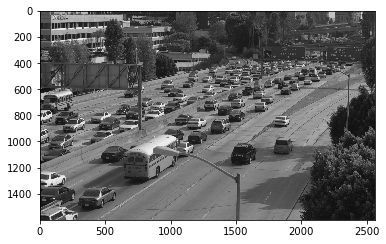

In [13]:
img = frame_processing(seq_name,0)
yuv_img = Image.fromarray(img.astype('uint8')).convert('YCbCr')

print("origin frame:")
plt.imshow(yuv_img)

In [14]:
def frame_padding(frame,CTU_size = 128):
    width , height = frame.shape[1],frame.shape[0]
    #print(width,height)
    width_CTU_nums = math.ceil(width/128)
    height_CTU_nums = math.ceil(height/128)
    pad_frame = np.zeros((height_CTU_nums*128,width_CTU_nums*128))
    for x in range(height):
        for y in range(width):
            pad_frame[x][y] = frame[x][y]
    return pad_frame

padding frame:


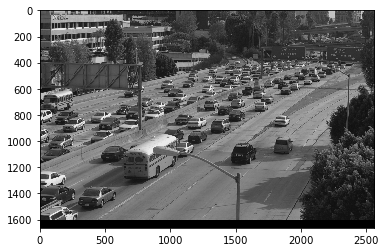

In [15]:
yuv_img_padding = frame_padding(img)
print("padding frame:")
yuv_img_padding = Image.fromarray(yuv_img_padding.astype('uint8')).convert('YCbCr')
plt.imshow(yuv_img_padding)

# BackBone

In [14]:

seq_list = ["Tango2","FoodMarket4","Campfire","CatRobot1","DaylightRoad2","ParkRunning3","MarketPlace","RitualDance",
            "Cactus","BasketballDrive","BQTerrace","RaceHorsesC","BQMall","PartyScene","BasketballDrill","RaceHorses",
            "BQSquare","BlowingBubbles","BasketballPass","FourPeople","Johnny","KristenAndSara"
            ]

QPList = ["QP22","QP27","QP32","QP37"]

def gen_range(yuv_img,yuv_img_padding,currframe = 0,index = 0,rd_mataining={}):
    org_width,org_height = yuv_img.size
    width , height = yuv_img_padding.size
    
    InFirstCTU = 0
    with open(prediction_path+'frame'+str(currframe)+'.txt', 'w') as f:
        for blocky in range(0, height, 128):
            for blockx in range(0, width, 128):
                for beginy in range(blocky, blocky+128, 32):
                    for beginx in range(blockx, blockx+128, 32):
                        if beginx > org_width or beginx + 32 > org_width or beginy > org_height or beginy + 32 > org_height:
                            continue
                        val = ""
                        val += str(beginx)+" "+str(beginy)+" "+str(beginx+32)+" "+str(beginy+32)+" "
                        item = pred_all[index]
                        #print(item)
                        #InFirstCTU+=1
                        
                        for ele in rd_mataining[item]:
                            val += str(ele)+" "
                            

                        f.write("%s\n" % (val))
                        index+=1
                        InFirstCTU+=1
    return index

In [ ]:
for QP in QPList:
    for seq_name in seq_list:
        pred_all = []
        checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile/best_weight_branch1.h5"
        model.load_weights(checkpoint_path,by_name=True)       
        test_path = "/"+QP+"_block"
        idx = 0

        for i in range(13):

            predict_label = []
            test_dir = "D:/frame/"+seq_name+test_path+"/test"+str(i)
            print(test_dir)
            test_image_generator = ImageDataGenerator(rescale = 1./255)
            test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                                          directory=test_dir,
                                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                          shuffle=False,
                                                                          class_mode=None)

            prediction=model.predict_generator(test_data_gen,verbose=1)



            predict_label=np.argmax(prediction,axis=1)
            for label in predict_label:
                pred_all.append(label)

                
        rd_mataining = {0:[2,2,3,0],1:[2,4,4,0],2:[2,5,4,2]} #(5-6,7-8,9-10)
        #prediction_path = "D:/frame/"+seq_name+"/Prediction/"+QP+"/"
        prediction_path = "D:/frame/"+seq_name+"/re_pred/"+QP+"/"
        index = 0
        for i in range(13):
            img = frame_processing(seq_name,i)
            yuv_img = Image.fromarray(img.astype('uint8')).convert('YCbCr')
            yuv_img_padding = frame_padding(img)
            yuv_img_padding = Image.fromarray(yuv_img_padding.astype('uint8')).convert('YCbCr')
            index = gen_range(yuv_img,yuv_img_padding,i,index,rd_mataining)

# BackBone & Three Branch

In [16]:

seq_list = ["Tango2","FoodMarket4","Campfire","CatRobot1","DaylightRoad2","ParkRunning3","MarketPlace","RitualDance",
             "Cactus","BasketballDrive","BQTerrace","ParkScene","RaceHorsesC","BQMall","PartyScene","BasketballDrill","RaceHorses",
             "BQSquare","BlowingBubbles","BasketballPass","FourPeople","Johnny","KristenAndSara"
             ]


QPList = ["QP22","QP27","QP32","QP37"]

def gen_range(yuv_img,yuv_img_padding,currframe = 0,index = 0,rd_mataining={}):
    org_width,org_height = yuv_img.size
    width , height = yuv_img_padding.size
    
    InFirstCTU = 0
    with open(prediction_path+'frame'+str(currframe)+'.txt', 'w') as f:
        for blocky in range(0, height, 128):
            for blockx in range(0, width, 128):
                for beginy in range(blocky, blocky+128, 32):
                    for beginx in range(blockx, blockx+128, 32):
                        if beginx > org_width or beginx + 32 > org_width or beginy > org_height or beginy + 32 > org_height:
                            continue
                        val = ""
                        val += str(beginx)+" "+str(beginy)+" "+str(beginx+32)+" "+str(beginy+32)+" "
                        item = pred_all[index]
                        #print(item)
                        #InFirstCTU+=1
                        if index in candidate_idx:

                            #print(candidate_idx)
                            qtitem = pred_conf_label[index]

                            if qtitem == 0:
                                pred_all[index] = 3
                                #print('in')
                                for ele in rd_mataining[3]:
                                    val += str(ele)+" "

                            else:
                                pred_all[index] = 4
                                for ele in rd_mataining[4]:
                                    val += str(ele)+" "
                        elif index in candidate_idx_mid:

                            qtitem = pred_conf_label_mid[index]

                            if qtitem == 0:
                                pred_all[index] = 5
                                #print('in')
                                for ele in rd_mataining[5]:
                                    val += str(ele)+" "
                                

                            else:
                                pred_all[index] = 6
                                #print('in')
                                for ele in rd_mataining[6]:
                                    val += str(ele)+" "
                                    
                        elif index in candidate_idx_QT12:

                            qtitem = pred_conf_label_QT12[index]

                            if qtitem == 0:
                                pred_all[index] = 7
                                #print('in')
                                for ele in rd_mataining[7]:
                                    val += str(ele)+" "
                                

                            else:
                                pred_all[index] = 8
                                #print('in')
                                for ele in rd_mataining[8]:
                                    val += str(ele)+" "
                        else:
                            for ele in rd_mataining[item]:
                                val += str(ele)+" "
                        #print(pred_all_tt)
                        if pred_all_tt[index] == 0:
                            val += "1"
                        else :
                            val += "0"
                        f.write("%s\n" % (val))
                        index+=1
                        InFirstCTU+=1
    return index

In [ ]:
checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile/best_weight_branch1.h5"
model.load_weights(checkpoint_path,by_name=True) 
checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_b2/best_weight_branch2.h5"
model.load_weights(checkpoint_path,by_name=True) 
checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_b3/best_weight_branch3.h5"
model.load_weights(checkpoint_path,by_name=True) 
checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_b4/best_weight_branch4.h5"
model.load_weights(checkpoint_path,by_name=True) 
checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_tt/best_weight_branch_tt.h5"
model.load_weights(checkpoint_path,by_name=True) 

In [ ]:
for QP in QPList:
    for seq_name in seq_list:
        pred_all = []
        pred_all_tt = []
        checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile/best_weight_branch1.h5"
        model.load_weights(checkpoint_path,by_name=True) 
        checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_b2/best_weight_branch2.h5"
        model.load_weights(checkpoint_path,by_name=True) 
        checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_b3/best_weight_branch3.h5"
        model.load_weights(checkpoint_path,by_name=True) 
        checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_b4/best_weight_branch4.h5"
        model.load_weights(checkpoint_path,by_name=True) 
        checkpoint_path = "./checkpoint/ckpt_"+QP+"_mobile_tt/best_weight_branch_tt.h5"
        model.load_weights(checkpoint_path,by_name=True) 

        candidate_idx = []
        pred_conf_label = []
        candidate_idx_mid = []
        pred_conf_label_mid = []
        candidate_idx_QT12 = []
        pred_conf_label_QT12 = []
        
        Threshold_TT = 0.5
        Threshold_QT2 = 0.6
        Threshold_QT3 = 0.6
        Threshold_QT12 = 0.5
        Threshold_QT78 = 0.5
        
        test_path = "/"+QP+"_block"
        idx = 0
        idx_mid = 0
        idx_QT12 = 0
        idx_tt = 0
        for i in range(13):

            predict_label = []
            test_dir = "D:/frame/"+seq_name+test_path+"/test"+str(i)
            print(test_dir)
            test_image_generator = ImageDataGenerator(rescale = 1./255)
            test_data_gen = test_image_generator.flow_from_directory(batch_size=256,
                                                                          directory=test_dir,
                                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                          shuffle=False,
                                                                          class_mode=None)
            #with tf.device('/cpu:0'):
            prediction,pred_QT,pred_QT_mid,pred_QT12,pred_tt=model.predict_generator(test_data_gen,verbose=1)



            predict_label=np.argmax(prediction,axis=1)
            ###
            predict_label_tt=np.argmax(pred_tt,axis=1)
            for label in predict_label_tt:
                pred_all_tt.append(label)
            #print(pred_all_tt)
            ###
            for label in predict_label:
                pred_all.append(label)

            pred_QT_label = np.argmax(pred_QT, axis=1)
            pred_QT_mid_label = np.argmax(pred_QT_mid, axis=1)#
            pred_QT12_label = np.argmax(pred_QT12, axis=1)#
            #print(pred_QT12_label)
            
            ################  TT branch  ###############
  
            for pred in pred_tt[:]:
                if np.amax(pred, axis=0) < Threshold_TT and pred_all_tt[idx_tt] == 1:
                    pred_all_tt[idx_tt] = 0
                
                idx_tt+=1
            ################  TT branch  ###############
            
            
            ################  Depth910 QT 23 branch  ###############
            for label in pred_QT_label:
                pred_conf_label.append(label)
            for pred in pred_QT[:]:
                if((np.amax(pred, axis=0) >= Threshold_QT2 and pred_conf_label[idx] == 0)and pred_all[idx] == 2):
                    candidate_idx.append(idx)
                elif((np.amax(pred, axis=0) >= Threshold_QT3 and pred_conf_label[idx] == 1)and pred_all[idx] == 2):
                    candidate_idx.append(idx)
                idx+=1
            ################  Depth78 QT 23 branch  ###############
            for label in pred_QT_mid_label:
                pred_conf_label_mid.append(label)
            for pred in pred_QT_mid[:]:
                if(np.amax(pred, axis=0) >= Threshold_QT78 and pred_all[idx_mid] == 1):
                    candidate_idx_mid.append(idx_mid)
                idx_mid+=1
             ################   QT 12 branch  ###############
            for label in pred_QT12_label:  
                pred_conf_label_QT12.append(label)
            for pred in pred_QT12[:]:
                if(np.amax(pred, axis=0) >= Threshold_QT12 and pred_all[idx_QT12] == 0):
                    candidate_idx_QT12.append(idx_QT12)
                idx_QT12+=1
                
        rd_mataining = {0:[2,2,3,0],1:[2,4,4,0],2:[2,5,4,2],3:[2,5,2,5],4:[3,4,4,2],5:[2,4,2,4],6:[3,2,4,0],7:[2,1,2,1],8:[2,2,3,0]} #(5-6,7-8,9-10)
        prediction_path = "D:/frame/"+seq_name+"/Prediction/"+QP+"/"
        #prediction_path = "D:/frame/"+seq_name+"/Pred2/"+QP+"/"
        index = 0
        for i in range(13):
            img = frame_processing(seq_name,i)
            yuv_img = Image.fromarray(img.astype('uint8')).convert('YCbCr')
            yuv_img_padding = frame_padding(img)
            yuv_img_padding = Image.fromarray(yuv_img_padding.astype('uint8')).convert('YCbCr')
            index = gen_range(yuv_img,yuv_img_padding,i,index,rd_mataining)